In [1]:
import pandas as pd 
import numpy as np
import sys
import os

from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import spacy 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

from sklearn.cluster import KMeans

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns

import pprint

In [2]:
nlp=spacy.load('pt_core_news_sm')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\011708631\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
filenames = os.listdir('data')

In [4]:
licita = []
licita_all = np.NaN

cols = ['CD_ORGAO', 'NM_ORGAO', 'NR_LICITACAO', 'ANO_LICITACAO', 'CD_TIPO_MODALIDADE', 'NR_COMISSAO', 'ANO_COMISSAO', 'TP_COMISSAO', 'NR_PROCESSO', 'ANO_PROCESSO', 'TP_OBJETO', 'CD_TIPO_FASE_ATUAL', 'TP_LICITACAO', 'DS_OBJETO', 'VL_LICITACAO', 'VL_HOMOLOGADO']

for path in filenames:
    aux = pd.read_csv(os.path.join('data', path, 'licitacao.csv'), usecols=cols)

    licita.append(aux)

    if type(licita_all)==type(np.NaN):
        licita_all = aux

    else:
        licita_all = licita_all.append(aux)

In [5]:
item = []
item_all = np.NaN

for path in filenames:
    aux = pd.read_csv(os.path.join('data', path, 'item.csv'), usecols=[n for n in range (0,13)])

    item.append(aux)

    if type(item_all)==type(np.NaN):
        item_all = aux

    else:
        item_all = item_all.append(aux)

C:\Users\011708631\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
item_all = item_all.dropna()
licita_all = licita_all.dropna()

## Data cleaning

In [7]:
stopwords = nltk.corpus.stopwords.words('portuguese') # Carregamento das stopwords em português

# Caracteres especiais a serem deletados. Sendo unidades de medida e símbolos especiais que não agregam valor a análise
filter_out = stopwords + ['kg', 'm', 'cm', 'mm', 'mg', 'ml', 'm²', '-', '+', '=', 'mcg', 'nº', 'g', 'ª', 'º']

# Função de tratamento
def processing_tokenization(sentence):
    sentence = sentence.lower() # Caixa baixa
    sentence = re.sub(r"[^\w\s]", "",sentence) # Exclusão de caracteres especiais
    sentence = re.sub("[0-9]+","", sentence) # Exclusão de dígitos
    sentence = re.sub("/+","", sentence) # Exclusão de "/"
    sentence = re.sub(' +', ' ', sentence) # Exclusão de espaçamentos repetitivos entre as frases

    doc=nlp(sentence) # Tokenização

    tokens=[token.text for token in doc]
    tokens=[token for token in tokens if token not in filter_out] # Filtragem adicional com os caracteres em filter_out

    return tokens

In [14]:
item_all['DS_ITEM_TOK'] = item_all['DS_ITEM'].apply(lambda x: processing_tokenization(x))

KeyboardInterrupt: 

In [15]:
licita_all['DS_OBJECT_TOK'] = licita_all['DS_OBJETO'].apply(lambda x: processing_tokenization(x))

KeyboardInterrupt: 

## Vectorizer and KMeans

In [16]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(min_df = 30, lowercase=False, tokenizer=identity_tokenizer)
tfidf = vectorizer.fit_transform(licita_all['DS_OBJECT_TOK'])

KeyError: 'DS_OBJECT_TOK'

In [17]:
import warnings
warnings.filterwarnings('ignore')

wcss = []
minimum=2
maximum=45
step=3

for n in tqdm(range(minimum, maximum, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(tfidf)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimum, maximum, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Intracluster Squared Sum")
plt.show()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [18]:
kmeans_model = KMeans(n_clusters=20, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)

X = kmeans_model.fit(tfidf)

labels=kmeans_model.labels_.tolist()

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [19]:
licita_all['topic'] = labels 
licita_all.to_csv('licita_modeled_20_tfidf.csv')

NameError: name 'labels' is not defined

In [20]:
licita_all[licita_all['topic']==19][['DS_OBJETO','topic']].head(20)

KeyError: 'topic'

In [21]:
remap_clusters = {0:'Medical and pharmaceutical supplies'
                    , 1:'Cars, parts and specialized labor'
                    , 2:'Gastos com vacinas (humanas e animais)'
                    , 3:'Expenses with vaccines (human and animal)'
                    , 4:'Works and renovations'
                    , 5:'Others'
                    , 6:'Transportation'
                    , 7:'Medicines'
                    , 8:'Office/Office Supplies'
                    , 9:'Others'
                    , 10:'Aquisição de material geral'
                    , 11:'General material acquisition'
                    , 12:'Services provision'
                    , 13:'Others'
                    , 14:'Collection and Sanitary Engineering'
                    , 15:'Services provision'
                    , 16:'Others'
                    , 17:'Specialized consultancy and advisory services'
                    , 18:'Services provision'
                    , 19:'General material acquisition'}

licita_all['TOPICS'] = licita_all['topic'].map(remap_clusters)

KeyError: 'topic'

In [22]:
licita_all_purchases = licita_all[licita_all['TP_OBJETO']=='COM']

In [23]:
purchases = licita_all_purchases['NR_LICITACAO']

In [24]:
item_all_purchases = item_all[item_all['NR_LICITACAO'].isin(purchases)]

In [25]:
vectorizer = TfidfVectorizer(min_df = 30, lowercase=False, tokenizer=identity_tokenizer)
tfidf = vectorizer.fit_transform(item_all_purchases['DS_ITEM_TOK'])

KeyError: 'DS_ITEM_TOK'

In [26]:
wcss = []
minimum=2
maximum=45
step=3

for n in tqdm(range(minimum, maximum, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(tfidf)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimum, maximum, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [27]:
kmeans_model = KMeans(n_clusters=14, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)

X = kmeans_model.fit(tfidf)

labels=kmeans_model.labels_.tolist()

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [28]:
item_all_purchases['topic'] = labels 

item_all_purchases.to_csv('item_modeled_14_tfidf.csv')

NameError: name 'labels' is not defined

In [29]:
item_all_purchases[['DS_ITEM', 'topic']][item_all_purchases['topic']==13].tail(20)

KeyError: "['topic'] not in index"

In [30]:
remap_clusters = {0:'Móveis'
                    , 1:'Printers, Toners and Cartridges'
                    , 2:'Hydraulic Materials, Tubes and Connections'
                    , 3:'Materials for renovation and construction'
                    , 4:'Others'
                    , 5:'Others'
                    , 6:'Tires and retread services'
                    , 7:'Inputs for civil construction'
                    , 8:'Electrical Installation Materials'
                    , 9:'Others'
                    , 10:'Inputs for civil construction'
                    , 11:'Food kinds'
                    , 12:'Medicine'
                    , 13:'Others'}

item_all_purchases['TOPICS'] = item_all_purchases['topic'].map(remap_clusters)

KeyError: 'topic'

## Data Analysis

In [31]:
licitacoes = pd.read_csv('licita_modeled_final.csv', index_col=0)
licitacoes.head()

FileNotFoundError: [Errno 2] No such file or directory: 'licita_modeled_final.csv'

In [32]:
other_licitacoes = licitacoes[licitacoes['TOPICS']!='Outros']

for year in other_licitacoes['ANO_LICITACAO'].unique():
    labels = [str(i)[8:-2] for i in list(other_licitacoes[other_licitacoes['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'TOPICS']).size().index)]

    colors=['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple', 'gainsboro', 'lime', 'orangered', 'moccasin', 'seashell', 'slategrey', 'cadetblue', 'olivedrab']

    ax = other_licitacoes[other_licitacoes['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'TOPICS']).size().plot(kind='pie', figsize=[23,12], colors=colors, autopct='%1.1f%%', labels=None, explode=(0, 0, 0.6, 0.3, 0.6, 0, 0, 0, 0, 0, 0, 0, 0))

    ax.get_yaxis().set_visible(False)

    plt.legend(loc="best", labels=labels)
    plt.show()

NameError: name 'licitacoes' is not defined

In [33]:
df = licitacoes.groupby(['ANO_LICITACAO', 'TOPICS']).size()

licitacoes_year = df.reset_index().pivot(index='ANO_LICITACAO', columns=['TOPICS'])

licitacoes_year = licitacoes_year.droplevel(0, axis=1)

NameError: name 'licitacoes' is not defined

NameError: name 'licitacoes_por_ano' is not defined

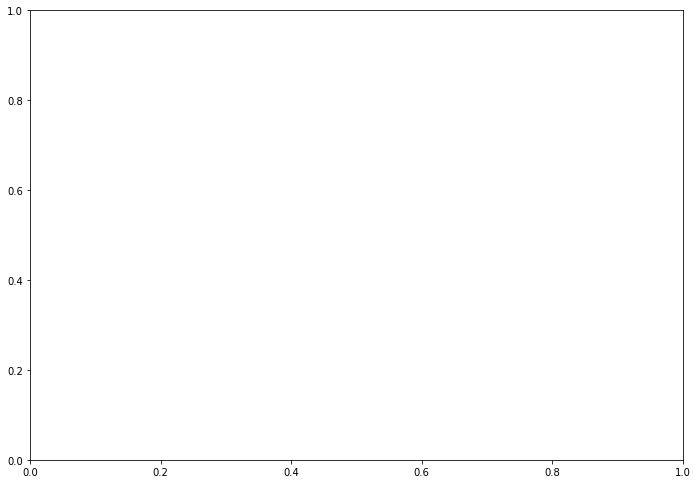

In [34]:
fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)
sns.heatmap(licitacoes_year.pct_change().dropna(), cmap=sns.color_palette('crest', 10))

In [40]:
def scientific(x, pos):
    # x:  tick value - ie. what you currently see in yticks
    # pos: a position - ie. the index of the tick (from 0 to 9 in this example)~
    x = int(x)
    return "{:,}".format(x)

ax = licitacoes[['VL_LICITACAO', 'TOPICS']].boxplot(by='TOPICS', showfliers=False, figsize=[23,12])

scientific_formatter = FuncFormatter(scientific)
ax.yaxis.set_major_formatter(scientific_formatter)

plt.xticks(rotation=45)

plt.show()

NameError: name 'licitacoes' is not defined

In [41]:
purchases = pd.read_csv('item_modeled_final.csv', index_col=0)
purchases.head()

FileNotFoundError: [Errno 2] No such file or directory: 'item_modeled_final.csv'

In [42]:
other_purchases = purchases[purchases['TOPICS']!='Outros']

for year in other_purchases['ANO_LICITACAO'].unique():

    labels = [str(i)[8:-2] for i in list(other_purchases[other_purchases['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'TOPICS']).size().index)]

    colors=['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple', 'gainsboro', 'lime', 'orangered', 'moccasin', 'seashell', 'slategrey', 'cadetblue', 'olivedrab']

    ax = other_purchases[other_purchases['ANO_LICITACAO']==year].groupby(['ANO_LICITACAO', 'TOPICS']).size().plot(kind='pie', figsize=[23,12], colors=colors, autopct='%1.1f%%', labels=None)

    ax.get_yaxis().set_visible(False)

    plt.legend(loc="best", labels=labels)
    plt.show()

NameError: name 'purchases' is not defined

In [43]:
df = purchases.groupby(['ANO_LICITACAO', 'TOPICS']).size()

purchases_year = df.reset_index().pivot(index='ANO_LICITACAO', columns=['TOPICS'])

purchases_year = purchases_year.droplevel(0, axis=1)


fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)
sns.heatmap(purchases_year.pct_change().dropna(), cmap=sns.color_palette('crest', 30))

NameError: name 'purchases' is not defined

In [44]:
purchases_year.pct_change()

NameError: name 'purchases_year' is not defined

In [45]:
ax = purchases[['VL_TOTAL_ESTIMADO', 'TOPICS']].boxplot(by='TOPICS', showfliers=False, figsize=[23,12])

scientific_formatter = FuncFormatter(scientific)
ax.yaxis.set_major_formatter(scientific_formatter)

plt.xticks(rotation=45)

plt.show()

NameError: name 'purchases' is not defined